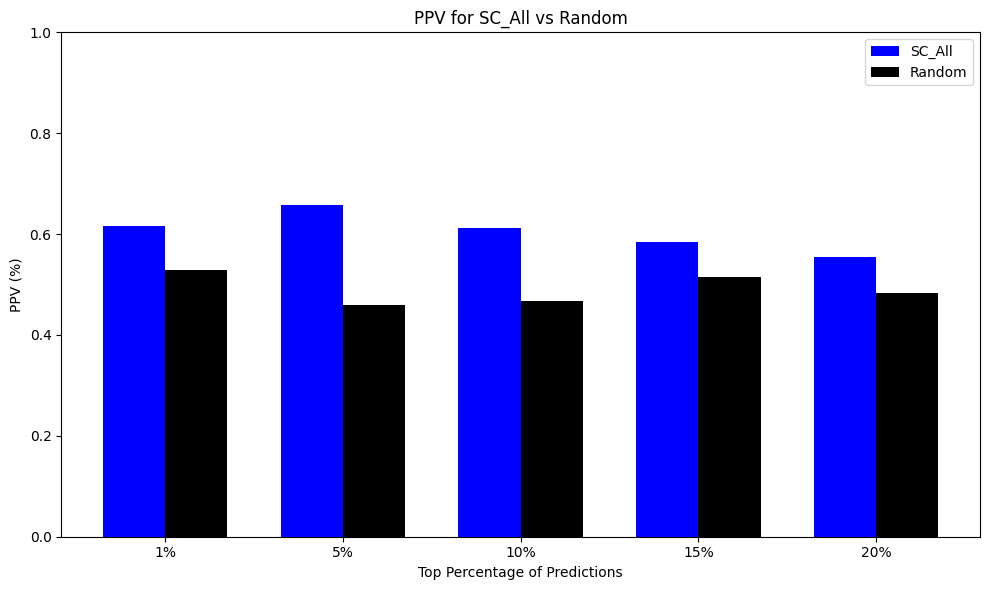

Optimal number of features: 5


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Funzione per calcolare PPV al top percentili
def calculate_top_percentile_ppv(probabilities, true_labels, percentiles):
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_labels = true_labels[sorted_indices]
    ppv_percentiles = []

    for p in percentiles:
        n_top = int(len(sorted_labels) * (p / 100))
        top_labels = sorted_labels[:n_top]
        ppv = np.sum(top_labels) / len(top_labels) if len(top_labels) > 0 else 0
        ppv_percentiles.append(ppv)

    return ppv_percentiles

# Caricamento dei dati discretizzati con LabelEncoder
def load_discretized_data():
    file_path = './cerevisiae_data.xls'
    discretized_data = pd.read_excel(file_path, sheet_name='entropy discretized')

    columns_with_symbols = discretized_data.columns[2:]  # Saltiamo 'Essential' e 'orf_id'
    label_encoders = {}

    for column in columns_with_symbols:
        le = LabelEncoder()
        discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
        label_encoders[column] = le

    return discretized_data.drop(columns=['Essential', 'orf_id']), discretized_data['Essential']

# Caricamento dei dati
X, y = load_discretized_data()

# Ranking CMIM fornito
CMIM_ranking = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus', 'nucleus',
                'upstream_size', 'spindle pole', 'GLU', 'Codon_bias', 'aromaticity_score', 'Gravy_score',
                'CAI', 'downstream_size', 'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP', 'ER to Golgi', 'GLN',
                'peroxisome', 'num places loc', 'LYS', 'ambiguous', 'cell periphery', 'FOP_score', 
                'nuclear periphery', 'ARG', 'Golgi to ER', 'punctate composite', 'ER', 'lipid particle',
                'microtubule', 'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']
X_ranked = X[CMIM_ranking]

# Percentuali per PPV
percentiles = [1, 5, 10, 15, 20]
n_iterations = 100
optimal_features = None
highest_ppv_1 = 0

# Probabilità per ciascun gene
gene_probabilities = np.zeros(len(y))

for i in range(len(CMIM_ranking), 0, -1):
    X_selected = X_ranked.iloc[:, :i]

    ppv_1_scores = []

    for _ in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.5, stratify=y)

        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train, y_train)

        y_prob = nb_classifier.predict_proba(X_test)[:, 1]
        ppv_top = calculate_top_percentile_ppv(y_prob, y_test.to_numpy(), percentiles)
        ppv_1_scores.append(ppv_top[0])

        # Aggiornamento delle probabilità globali
        gene_indices = y_test.index
        gene_probabilities[gene_indices] += y_prob

    mean_ppv_1 = np.mean(ppv_1_scores)

    if mean_ppv_1 > highest_ppv_1:
        highest_ppv_1 = mean_ppv_1
        optimal_features = i

gene_probabilities /= n_iterations

# Valutazione finale
gene_probabilities_final = np.zeros(len(y))

X_optimal = X_ranked.iloc[:, :optimal_features]

for _ in range(n_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_optimal, y, test_size=0.5, stratify=y)

    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)

    y_prob = nb_classifier.predict_proba(X_test)[:, 1]
    gene_indices = y_test.index
    gene_probabilities_final[gene_indices] += y_prob

gene_probabilities_final /= n_iterations

# Grafico finale
fig, ax = plt.subplots(figsize=(10, 6))
sc_all_ppv = calculate_top_percentile_ppv(gene_probabilities_final, y.to_numpy(), percentiles)
random_ppv = [np.mean(y) for _ in percentiles]  # Fandom calcolato come proporzione di geni essenziali

width = 0.35
labels = [f'{p}%' for p in percentiles]
ax.bar(np.arange(len(percentiles)) - width/2, sc_all_ppv, width, label='SC_All', color='blue')
ax.bar(np.arange(len(percentiles)) + width/2, random_ppv, width, label='Random', color='black')

ax.set_xlabel('Top Percentage of Predictions')
ax.set_ylabel('PPV (%)')
ax.set_title('PPV for SC_All vs Random')
ax.set_xticks(np.arange(len(percentiles)))
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

print(f"Optimal number of features: {optimal_features}")
